In [1]:
import os
import numpy as np
from PIL import Image
import argparse
import cv2
import scipy.sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import imutils
import pandas as pd

import itertools
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

import time
import random
import math

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

!conda info --env

%matplotlib inline



# conda environments:
#
base                     C:\Users\yongwook\anaconda3
outline               *  C:\Users\yongwook\anaconda3\envs\outline



In [2]:

import sys



def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [3]:
data_dir = "./AutoAlign"
test_dir = "./AutoAlign_test"
# made test images never get into data directory.
weights_path = 'face_landmarks_transfer_'

landmark_regex_string = '29@[2479]|30@[34]' # for 18: '29@[1-9]\d?|30@[1-7]'
landmark_number = 6

photo_postfix = "lat_photo.jpg"
tsv_postfix = "lat_photo.txt"


# ML Playground (CNN, mostly)

## Creating Dataset
Based on above information, we can create custom dataset. 사실 Dataset만 상속받고 나머지는 알아서 잘 해도 된다 하더라.

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://blog.paperspace.com/dataloaders-abstractions-pytorch/
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html



In [4]:
class CustomDataSet(Dataset):


    def __init__(self, data_dir: str, image_postfix:str, tsv_postfix:str, landmark_regex:str, landmark_length:int):
        

        self.photo_img_string = image_postfix
        self.photo_tsv_string = tsv_postfix
        self.data_dir = data_dir
        self.landmark_regex = landmark_regex
        self.landmark_length = landmark_length

        files = os.listdir(self.data_dir)

        self.photo_images = [x for x in files if self.photo_img_string in x]
        self.photo_tsvs = [x for x in files if self.photo_tsv_string in x]
        assert(len(self.photo_images) == len(self.photo_tsvs))
        for i in range(len(self.photo_images)):
            x, y = self.photo_images[i], self.photo_tsvs[i]
            assert(os.path.splitext(x)[0] == os.path.splitext(y)[0])

    def __len__(self):
        return len(self.photo_tsvs)

    # load_tsv: load tsv --> return dataframe with name, x, y column.
    def load_tsv(self, name):
        # Loading dataframe
        df = pd.read_csv(os.path.join(self.data_dir, name),  sep='\t')
        df = df.iloc[:99, 0:3]
        
        df.columns = ['name', 'X', 'Y']

        return df


    # load_image: load image --> return plt.Image grayscale.
    def load_image(self, name):
        image = cv2.imread(os.path.join(self.data_dir, name), flags=cv2.IMREAD_GRAYSCALE)
        img = Image.fromarray(image)
        return img

    # bounding_box: df(name, x, y) --> return top, left, height, width in integer
    def bounding_box(self, df):
        center = df[df['name'] == '2']

        cy, bottom, cx, right = center['Y'].values[0], df['Y'].max(), center['X'].values[0], df['X'].max()
        dy, dx = bottom - cy, right - cx
        top, left = cy - dy, cx
        # print((left, top), (right, bottom))
        # creating bounding box
        width, height = (right - left), (bottom - top)
        # rand_size_bias = random.uniform(0.9, 1.1)
        # width, height = width * rand_size_bias, height * rand_size_bias

        return int(top), int(left), int(height), int(width)


    def add_random_bias(self, top, left, height, width, bias=0.01):
        top_bias = int(random.uniform(-height*bias,0))
        left_bias = int(random.uniform(-width*bias,0))
        height_bias = -top_bias + int(random.uniform(0, height*bias))
        width_bias = -left_bias + int(random.uniform(0, width*bias))
        top, left, height, width = top + top_bias, left + left_bias, height + height_bias, width + width_bias
        return top, left, height, width

    def extract_landmarks(self, df, landmark_regex, landmark_length):
        # (gathering only needed landmarks)
        df = df.loc[df['name'].str.contains(landmark_regex, regex=True), :]
        # there are **18** landmarks that is unique and valid among all files
        # should we sort df?
        df = df.sort_values(by=['name'])
        df = df.loc[:, ['X', 'Y']]
        df = df.reset_index(drop=True)

        # ... and landmark
        landmark = df.to_numpy(dtype=np.float32)
        return landmark

    def rotate(self, img, landmark, angle):
        angle = random.uniform(-angle, +angle)

        
        transformation_matrix = torch.tensor([
            [+math.cos(math.radians(angle)), -math.sin(math.radians(angle))], 
            [+math.sin(math.radians(angle)), +math.cos(math.radians(angle))]
        ])

        image = imutils.rotate(np.array(img), angle)

        landmark = landmark - 0.5
        new_landmarks = np.matmul(landmark, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def crop(self, img, landmark, top, left, height, width):
        # Cropping image...
        img = TF.crop(img, top, left, height, width)
        #oh, ow = np.array(img).shape[0], np.array(img).shape[1]

        landmark = torch.tensor(landmark) - torch.tensor([[left, top]])
        landmark = landmark / torch.tensor([width, height])
        return img, landmark

    def normalize(self, img, landmark, height, width):
        # normalizing the pixel values
        img = TF.to_tensor(img)
        img = TF.normalize(img, [0.6945], [0.33497])


        landmark -= 0.5
        return img, landmark

    def __getitem__(self, index):
        
        img_name = self.photo_images[index]
        tsv_name = self.photo_tsvs[index]

        img = self.load_image(img_name)
        df = self.load_tsv(tsv_name)

        top, left, height, width = self.bounding_box(df)
        top, left, height, width = self.add_random_bias(top, left, height, width, 0.02)
        landmark = self.extract_landmarks(df, self.landmark_regex, self.landmark_length)

        # rand_top = int(top) + random.randint(-int(height * 0.1), int(height * 0.1))
        # rand_left = int(left) + random.randint(0, int(width * 0.2))

        img, landmark = self.crop(img, landmark, top, left, height, width)

        # resizing image..
        img = TF.resize(img, (224, 224))
        # packing image
        # use dsplit when RGB to make 224x224x3 --> 3x224x224
        #img = np.dsplit(img, img.shape[-1])

        img, landmark = self.rotate(img, landmark, 5)
        img, landmark = self.normalize(img, landmark, height, width)

        #arr = arr.flatten('F')

        return img, landmark, img_name

In [5]:


dataset = CustomDataSet(data_dir, photo_postfix, tsv_postfix, landmark_regex = landmark_regex_string, landmark_length = landmark_number)
test_dataset = CustomDataSet(test_dir, photo_postfix, tsv_postfix, landmark_regex = landmark_regex_string, landmark_length = landmark_number)
# split the dataset into validation and test sets
len_valid_set = len(dataset)
len_train_set = len(test_dataset)

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

# train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])


data_train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
print(len(data_train_loader))

valid_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

The length of Train set is 50
The length of Valid set is 454
8


In [6]:
# Display image and label.
train_features, train_labels, _ = next(iter(data_train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]

print(f"Label: {label}")
landmarks = (label + 0.5) * 224
print(f"landmarks: {landmarks}")
# plt.figure(figsize=(10, 10))
# plt.imshow(img.squeeze(), cmap='gray')
# plt.scatter(landmarks[:,0], landmarks[:,1], s=8)


Feature batch shape: torch.Size([64, 1, 224, 224])
Labels batch shape: torch.Size([64, 6, 2])
Label: tensor([[ 0.3813, -0.0671],
        [ 0.4887,  0.1190],
        [ 0.3771,  0.1740],
        [ 0.4176,  0.2688],
        [ 0.3758,  0.3042],
        [ 0.3280,  0.3480]])
landmarks: tensor([[197.4155,  96.9739],
        [221.4713, 138.6657],
        [196.4694, 150.9790],
        [205.5414, 172.2091],
        [196.1735, 180.1365],
        [185.4810, 189.9505]])


In [7]:
valid_prefix = []
with torch.no_grad():
    for batch_idx, (valid_feature, valid_landmark, valid_name) in enumerate(valid_loader, start=1):
        for name in valid_name:
            valid_prefix.append(name.replace("_photo.jpg", ""))

print(valid_prefix)

['48301___________000_lat', 'B15955___________000_lat', 'B15809___________000_lat', '0101___________000_lat', 'B10606___________000_lat', 'B19011___________000_lat', 'B22050___________000_lat', 'B22163___________000_lat', '17285___________000_lat', 'B16939___________000_lat', 'B13616___________000_lat', 'B23418___________000_lat', 'B12007___________001_lat', '14644377___________000_lat', 'B10243___________000_lat', 'B17545___________000_lat', '01042185___________3618_lat', 'B7887___________000_lat', 'B8753___________000_lat', 'B4151___________000_lat', '28800___________000_lat', 'B4867___________000_lat', 'B9871___________000_lat', 'B14138___________000_lat', 'B11375___________000_lat', 'B7524___________000_lat', 'B6863___________000_lat', '43476___________000_lat', '21706747___________000_lat', 'B17915___________000_lat', '19951816___________000_lat', 'B13247___________000_lat', 'B19857___________000_lat', 'B25776___________000_lat', '45325___________000_lat', 'B19358___________000_la

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Network
Based on https://colab.research.google.com/drive/1-28T5nIAevrDo6MwN0Qi_Cgdy9TEiSP_?usp=sharing#scrollTo=XH_bqPXo6YG8

Resnet50을 이용한다. 일단은 Greyscale(컬러로 확장도 가능하나 실익이 크지 않다.)

https://towardsdatascience.com/face-landmarks-detection-with-pytorch-4b4852f5e9c4

In [9]:
class Network(nn.Module):
    def __init__(self,num_classes=(landmark_number*2)):
        super().__init__()
        self.model_name='resnet50'
        #self.model=models.resnet18(pretrained=True)
        
        self.model=models.resnet50(pretrained=True)


        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # for param in self.parameters():
        #     param.requires_grad = False

        # RGB:        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

        
    def forward(self, x):
        x=self.model(x)
        return x

## Training
그림이 커서 그런지 초반에는 구데기로 나오고, 최소 100 epoch 이상은 해 줘야 할 것 같다.

- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- http://incredible.ai/artificial-intelligence/2017/05/13/Transfer-Learning/#%EC%83%88%EB%A1%9C-%ED%9B%88%EB%A0%A8%ED%95%A0-%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B0%80-%EC%A0%81%EC%9C%BC%EB%A9%B0-original-%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%99%80-%EB%8B%A4%EB%A5%B8-%EA%B2%BD%EC%9A%B0
- https://hanqingguo.github.io/Face_detection


In [10]:
# %%capture cap_out --no-stderr

torch.autograd.set_detect_anomaly(True)
network = Network()
# use load_state_dict to load previously trained model.
checkpoint = torch.load(f"model/0602_0025_6_100_face_landmarks_transfer__resnet50.tar")
# use pth only
# network.load_state_dict(torch.load(f"model/0525_1926_6_100_face_landmarks_transfer__resnext50.pth"))
# use checkpoint
network.load_state_dict(checkpoint['network_state_dict'])

network.cuda()
print(network)

criterion = nn.MSELoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, network.parameters()), lr=0.001)
# Load optimizer too
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

loss_min = np.inf
num_epochs = 100

logger = pd.DataFrame(columns=['train loss', 'valid loss'])

start_time = time.time()
time_str = time.strftime(f"%m%d_%H%M")
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(data_train_loader)+1):
    
        images, landmarks, _ = next(iter(data_train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = network(images)
        
        optimizer.zero_grad()
        
        loss_train_step = criterion(predictions, landmarks)
        
        loss_train_step.backward()
        
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(data_train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks, _ = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(data_train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    logger.loc[epoch - 1] = [loss_train, loss_valid]

    if loss_valid < loss_min:
        loss_min = loss_valid
        # torch.save(network.state_dict(), f"model/{time_str}_{landmark_number}_{num_epochs}_{weights_path}_{network.model_name}.pth") 
        torch.save({
            'network_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, f"model/{time_str}_{landmark_number}_{num_epochs}_{weights_path}_{network.model_name}.tar")
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
    
    # cap_out.show()
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
logger.to_csv(f'csv/{time_str}_{landmark_number}_{num_epochs}_train_data.csv')
# cap_out.show()
# with open(f'csv/{time_str}_{landmark_number}_{num_epochs}_train_log.txt') as capture_file:
#     capture_file.write(cap_out)

del network 

ride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (2): Bottleneck(
        (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
    (avgpool): Adap

In [10]:
def pixel_distance(landmark, reference):
    ''' pixel_distance(landmark: np.array[[x, y], ..] 
                        reference: np.array[[x, y]] with true landmark value

        return: average: float average distance,
                each: np.array[distance, ..] with distance of each landmark
    '''
    each = []
    for i in range(len(landmark)):
        each.append(np.linalg.norm(landmark[i] - reference[i]))

    each = np.array(each)
    average = np.average(each)

    return average, each


In [11]:
def pixel_difference(landmark, reference):
    each = np.empty((len(landmark), 2))
    for i in range(len(landmark)):
        each[i] = (landmark[i] - reference[i])

    print(each)
    
    return each

C:\Users\yongwook\anaconda3\envs\outline\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
5.6500716
[8.510263  2.3057432 2.8932598 5.476572  6.8592463 7.855341 ]
3.9099915
[3.3257222  0.67715865 2.9104009  3.3998578  5.117159   8.029652  ]
3.1767569
[3.9391189 1.346698  3.9939485 3.4504633 2.820711  3.5096009]
2.9156826
[3.2854583 2.8722296 1.4100596 3.043657  3.7155902 3.167101 ]
3.646656
[7.04087   2.3101368 1.773084  3.8261638 4.1954675 2.734215 ]
3.410361
[6.6931105 3.1203456 1.3326645 4.1964927 1.5050064 3.6145456]
1.9961066
[2.5500424  2.017601   0.9967066  0.90411717 5.1498146  0.35835832]
3.6490777
[2.5920844 1.6593632 3.251798  2.2035751 7.356184  4.831463 ]
Total number of test images: 50
Elapsed Time : 5.217835903167725


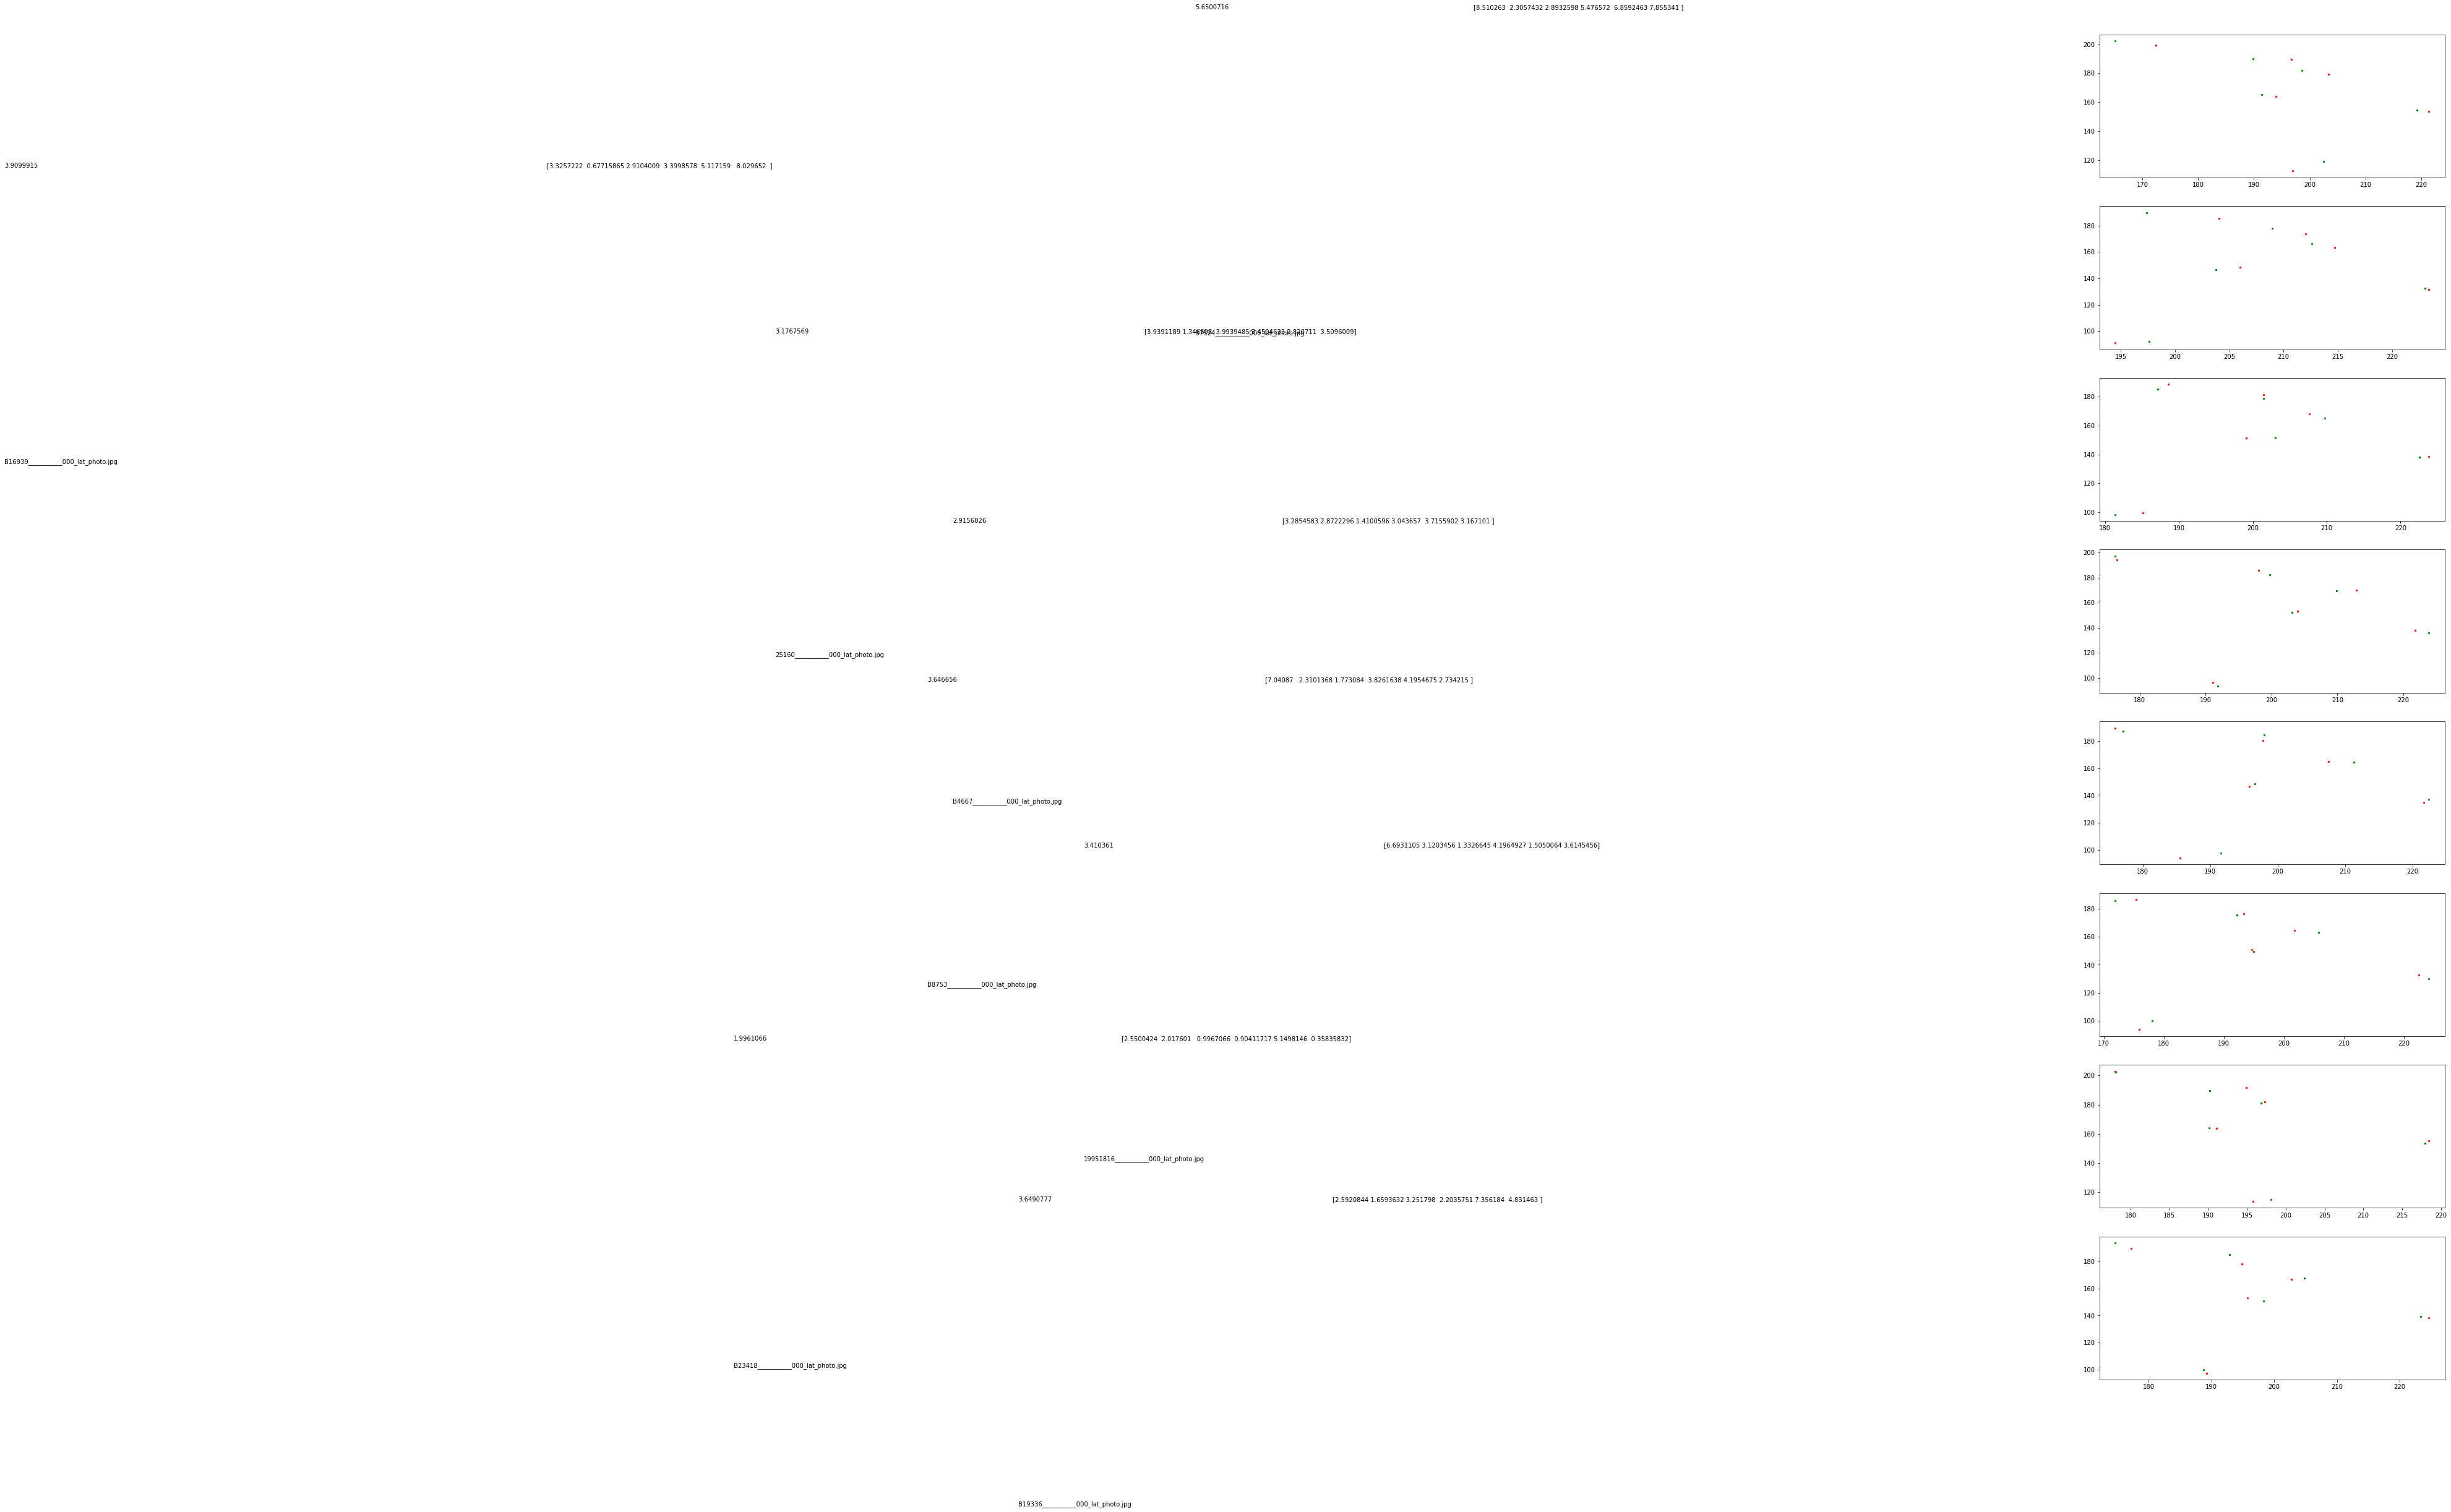

In [12]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load(f"model/0602_1303_6_100_face_landmarks_transfer__resnet50.tar")['network_state_dict'])
    best_network.eval()
    
    images, landmarks, names = next(iter(valid_loader))
    landmarks = (landmarks+0.5) * 224
    images = images.cuda()

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,landmark_number,2)


    
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        # plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)
        plt.text(0, 0, names[img_num])
        average, each = pixel_distance(predictions[img_num], landmarks[img_num])
        plt.text(0, 224, average)
        plt.text(50, 224, each)
        print(average)
        print(each)


print('Total number of test images: {}'.format(len(test_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

In [13]:
with torch.no_grad():

    valid_logger = pd.DataFrame(columns=['29@2', '29@4', '29@7', '29@9', '30@3', '30@4', 'Average'])

    valid_diff_logger = pd.DataFrame(columns=['29@2_x','29@2_y','29@4_x', '29@4_y', '29@7_x','29@7_y', '29@9_x','29@9_y', '30@3_x','30@3_y', '30@4_x', '30@4_y'])

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load(f"model/0602_1303_6_100_face_landmarks_transfer__resnet50.tar")['network_state_dict'])
    best_network.eval()


    
    for batch_idx, (valid_image, valid_landmark, valid_name) in enumerate(valid_loader, start=1):
        valid_landmark = (valid_landmark + 0.5)*224
        valid_image = valid_image.cuda()

        predictions = (best_network(valid_image).cpu() + 0.5) * 224
        predictions = predictions.view(-1,landmark_number,2)


        for img_num in range(len(valid_image)):
            index=(batch_idx-1)*8 + img_num
            average, each = pixel_distance(predictions[img_num], landmarks[img_num])
            diff = pixel_difference(predictions[img_num], landmarks[img_num])
            valid_logger.loc[index] = np.append(each, average)
            valid_diff_logger.loc[index] = diff.flatten()

    print(valid_logger)
    valid_logger.to_csv('statistics_distance.csv')
    valid_diff_logger.to_csv('statistics_difference.csv')



print('Total number of test images: {}'.format(len(test_dataset)))

[[-12.64976501 -31.69404602]
 [  4.7290802  -26.03935242]
 [ 12.54779053 -19.4006958 ]
 [ 14.82270813 -19.26402283]
 [ 14.77735901 -14.06210327]
 [ 24.15066528 -12.00743103]]
[[-21.0916748   11.9773407 ]
 [ -5.45884705  11.14509583]
 [-13.63542175  10.1880188 ]
 [-12.52073669   5.16680908]
 [ -4.05049133   1.70877075]
 [  1.49862671   2.8052063 ]]
[[  9.78123474  -4.54523468]
 [  1.31121826 -11.64886475]
 [ -2.05780029  -7.7401123 ]
 [ -1.14575195  -7.70722961]
 [  0.61915588  -8.77363586]
 [  4.88401794  -1.92677307]]
[[ -5.9597168   19.37902832]
 [ -2.83566284  15.29954529]
 [-11.10960388   8.92893982]
 [ -4.52256775   6.36561584]
 [  3.056427     7.11630249]
 [  7.39852905   3.36479187]]
[[-4.22630310e+00  3.30352783e-03]
 [ 1.60700989e+00 -5.37562561e+00]
 [ 4.89843750e+00  1.15016174e+00]
 [-1.01861572e+00  3.58624268e+00]
 [ 3.44885254e+00 -1.64759827e+00]
 [ 5.07409668e+00  7.65263367e+00]]
[[13.36061096 -0.97930908]
 [-1.93688965  4.93768311]
 [-0.12039185  0.9228363 ]
 [-0.413

## From Face detection to landmark detection, IRL

https://github.com/timesler/facenet-pytorch

- With pip:
pip install facenet-pytorch

- or clone this repo, removing the '-' to allow python imports:
git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

- or use a docker container (see https://github.com/timesler/docker-jupyter-dl-gpu):
docker run -it --rm timesler/jupyter-dl-gpu pip install facenet-pytorch && ipython

In [16]:
#######################################################################
def return_path (common_path):
    # common_path = r'AutoAlign_test\B25776___________000_lat'
    pi, pt, fi, ft = "_photo.jpg", "_photo.txt", "_film.jpg", "_film.txt"
    image_path = common_path + pi
    tsv_path = common_path + pt
    film_path = common_path + ft
    film_img_path = common_path + fi

    return image_path, tsv_path, film_img_path, film_path


image_path, tsv_path, film_img_path, film_path = return_path("AutoAlign_test/B9871___________000_lat")
#######################################################################


2992 2000
tensor([[ 0.3091, -0.0979,  0.4772,  0.0944,  0.3673,  0.1633,  0.3670,  0.2339,
          0.3333,  0.2720,  0.2593,  0.3364]])
[[1774.2092634   995.15263033]
 [1874.22702528 1195.21033001]
 [1808.85266311 1266.79521751]
 [1808.63412924 1340.28688145]
 [1788.60639699 1379.91770458]
 [1744.57263715 1446.8939085 ]]


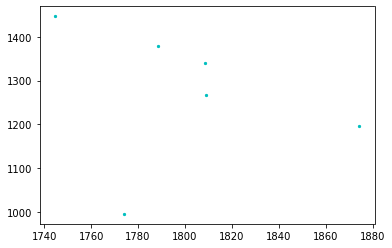

took about 2.327930212020874s
from image open, took 0.7689909934997559s
from inference, took 0.4999990463256836s


In [19]:
from facenet_pytorch import MTCNN, InceptionResnetV1

start = time.time()

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=224, device=device)

best_network = Network()
# best_network.load_state_dict(torch.load(f"model/{time_str}_{landmark_number}_{num_epochs}_{weights_path}_{best_network.model_name}.tar")['network_state_dict'])
best_network.load_state_dict(torch.load(f"model/0602_1303_6_100_face_landmarks_transfer__resnet50.tar")['network_state_dict'])
best_network.eval()


image_open = time.time()
input_image = Image.open(image_path)
grayscale_image = input_image.convert('L')
height, width = input_image.size[0], input_image.size[1]
print(height, width)
# Get cropped and prewhitened image tensor
boxes, probs = mtcnn.detect(input_image)
face = boxes[0]
x0, y0, x1, y1 = face
face_width = x1 - x0
x0, y0, x1, y1 = int(x0)+face_width * 0.05, int(y0), int(x1)+face_width * 0.05, int(y1) 

#face = (faces + 1) * 255

# image = np.array(grayscale_image)
# image = image[y0:y1, x0:x1]
# image = TF.crop(grayscale_image, y0, x0, y1-y0, x1-x0)
image = TF.resized_crop(grayscale_image, y0, x0, y1-y0, x1-x0, size=(224, 224))
# plt.imshow(image, cmap='gray')
# plt.imsave("profile_cut.png", image, cmap='gray')
# image = TF.resize(Image.fromarray(image), size=(224, 224))
image = TF.to_tensor(image)
image = TF.normalize(image, [0.6945], [0.33497])
from_image_inference = time.time()
with torch.no_grad():
   landmarks = best_network(image.unsqueeze(0))

print(landmarks)
landmarks = (landmarks.view(landmark_number,2).detach().numpy() + 0.5) * np.array([[x1-x0, y1-y0]]) + np.array([[x0, y0]])
print(landmarks)

plt.figure()
# plt.imshow(input_image)
plt.scatter(landmarks[:,0], landmarks[:,1], c = 'c', s = 5)
# plt.savefig('result.png', dpi=300)
plt.show()

end = time.time()
print(f"took about {end - start}s")
print(f"from image open, took {end - image_open}s")
print(f"from inference, took {end - from_image_inference}s")

In [20]:

def load_tsv(path):
    # Loading dataframe
    df = pd.read_csv(path,  sep='\t')
    df = df.iloc[:99, 0:3]
    
    df.columns = ['name', 'X', 'Y']

    return df

def extract_landmarks(df, landmark_regex, landmark_length):
    # (gathering only needed landmarks)
    df = df.loc[df['name'].str.contains(landmark_regex, regex=True), :]
    # there are **18** landmarks that is unique and valid among all files
    # should we sort df?
    df = df.sort_values(by=['name'])
    df = df.loc[:, ['X', 'Y']]
    df = df.reset_index(drop=True)

    # ... and landmark
    landmark = df.to_numpy(dtype=np.float32)
    return landmark

df = load_tsv(tsv_path)
correct_landmarks = extract_landmarks(df, '29@[2479]|30@[34]', 6)
print(landmarks)
print(correct_landmarks)
print(pixel_distance(landmarks, correct_landmarks))

[[1774.2092634   995.15263033]
 [1874.22702528 1195.21033001]
 [1808.85266311 1266.79521751]
 [1808.63412924 1340.28688145]
 [1788.60639699 1379.91770458]
 [1744.57263715 1446.8939085 ]]
[[1768.071   962.9441]
 [1855.243  1190.19  ]
 [1787.701  1248.747 ]
 [1783.926  1333.148 ]
 [1759.72   1377.001 ]
 [1724.88   1438.764 ]]
(26.047820249094958, array([32.78822472, 19.63659653, 27.80522917, 25.71876259, 29.03330718,
       21.30480131]))


In [21]:
def transform_landmarks(matrix, landmarks):
    '''
    transform_landmarks(matrix: np.array(), landmarks: np.array()):
        matrix: numpy.array(), a 2x3 matrix array which is affine transformation.
        landmarks: numpy.array(), a (n, 2) shaped array that contains landmarks information.

    1. Add "1" to each coordinate. (x, y) --> (x, y, 1)
    2. Transpose and multiply with matrix.
        [[a, b, c],   [[x,         [[x',
         [d, e, f]] X   y,      =    y'], ...]
                        1], ...] 
            matrix  X landmarks = transformed matrix
    3. Transpose back to original format, and return.

    returns:
        result: numpy.array(), a (n, 2) shaped array that contains transformed landmarks information.
        
    '''
    ones = np.ones((1, len(landmarks)))
    homography_landmarks = np.concatenate((landmarks, ones.T), axis=1)
    result = np.dot(matrix, homography_landmarks.T).T
    return result

[[ 4.50635557e-01  1.30970841e-02  1.01132192e+03]
 [-1.30970841e-02  4.50635557e-01  5.95604158e+02]]
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]]
[1011.3219230717305, 595.6041575002223, 0.45082584080706756, 1.6647520404689993]


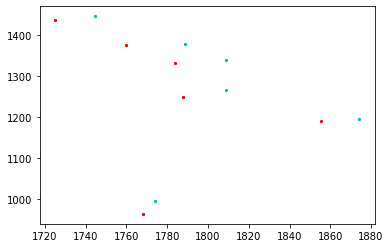

In [22]:
film_landmarks = extract_landmarks(load_tsv(film_path), '29@[2479]|30@[34]', 6)
matrix, inliers = cv2.estimateAffinePartial2D(film_landmarks[:], landmarks[:], method=cv2.LMEDS)
sol_matrix, sol_inliers = cv2.estimateAffinePartial2D(film_landmarks,correct_landmarks, method=cv2.LMEDS)
print(matrix)
print(inliers)

translation_x, translation_y = matrix[0, 2], matrix[1, 2]
scale = (matrix[0, 0] * matrix[0, 0] + matrix[1, 0] * matrix[1, 0]) ** 0.5
rotation = np.arctan2(matrix[0, 1], matrix[1, 1])
degree = np.rad2deg(rotation)
print([translation_x, translation_y, scale, degree])
# solution: [-764.8932178875267, -713.3610459581183, 1.9335031260399236, -0.6305061269798841]

output_string = f"translation_x={translation_x}\ntranslation_y={translation_y}\nscale={scale}\ndegree={degree}\n"
with open("output.txt", "w") as output:
    output.write(output_string)

plt.figure()
# plt.imshow(input_image)
plt.scatter(landmarks[:,0], landmarks[:,1], c = 'c', s = 5)
plt.scatter(correct_landmarks[:,0], correct_landmarks[:,1], c = 'r', s = 5)
plt.savefig('result.png', dpi=300)
plt.show()

In [23]:
# load_image: load image --> return opencv.
def load_image(path):
    img = Image.open(path)
    return img
film_image = load_image(film_img_path)
print(film_image.size)
corners = np.array([[0,0], [0, film_image.size[1]], [film_image.size[0], 0], [film_image.size[0], film_image.size[1]]])
ours = transform_landmarks(matrix, corners)
sol = transform_landmarks(sol_matrix, corners)
print(ours)
print(sol)
print(pixel_distance(ours, sol))



(2056, 2600)
[[1011.32192307  595.6041575 ]
 [1045.37434176 1767.2566054 ]
 [1937.82862802  568.67655257]
 [1971.88104671 1740.32900046]]
[[ 979.34489558  515.39452199]
 [ 965.72319242 1748.70794634]
 [1954.61120345  526.16614572]
 [1940.9895003  1759.47957007]]
(62.545117039301715, array([86.34880379, 81.78238407, 45.70327699, 36.34600331]))


In [24]:


# input_image_cv2 = np.array(input_image)
# warped_image = cv2.warpAffine(np.array(film_image), matrix, (input_image_cv2.shape[1], input_image_cv2.shape[0]))
# plt.figure()
# plt.imshow(input_image)
# plt.imshow(warped_image, alpha=0.5)
# plt.show()



In [25]:
dpi = (140,140)
one_dot_mm = (25.4 / dpi[0], 25.4 / dpi[1])
print(one_dot_mm)
average, each = pixel_distance(ours, sol)
print(average, each)
print((ours - sol) * [one_dot_mm])

(0.1814285714285714, 0.1814285714285714)
62.545117039301715 [86.34880379 81.78238407 45.70327699 36.34600331]
[[ 5.80154642 14.55231958]
 [14.45099424  3.36525671]
 [-3.04483869  7.71260238]
 [ 5.60460914 -3.47446049]]


In [26]:
print(input_image.size)
diff = (ours-sol) / np.array([input_image.size])
print(diff * 100)

(2992, 2000)
[[ 1.06875092  4.01048178]
 [ 2.66213734  0.92743295]
 [-0.56091495  2.12552034]
 [ 1.03247147 -0.95752848]]
